In [1]:
import jax
from jax import random, Array
import jax.numpy as jnp

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from typing import *

from gp import k, mk_cov, create_toy_dataset, PlotContext

key = random.PRNGKey(42)  # Create a random key                        

# Kernel Ridge Regression (KRR)

We introduce a model called **Kernel Ridge Regression** (KRR) that is closely related to GP regression. Like GP regression, KRR can be used to perform function approximation. We reintroduce our toy dataset from before below.

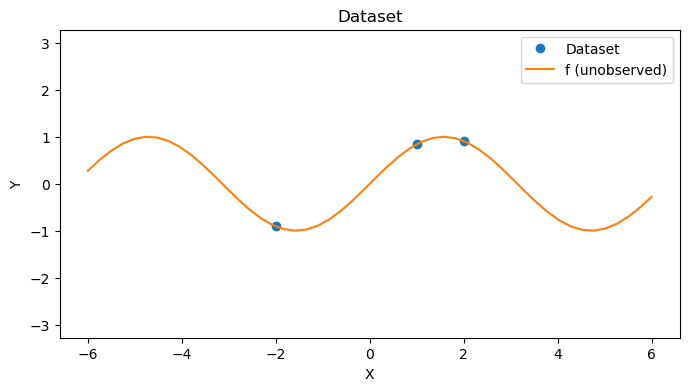

In [2]:
# Create dataset
f = lambda x: jnp.sin(x)
xs, ys = create_toy_dataset(f)
N = len(xs)
xs, ys

test_xs = jnp.linspace(-6, 6)
with PlotContext(title="Dataset", xlabel="X", ylabel="Y") as ax:
    plt.plot(xs, ys, marker="o", linestyle="None", label="Dataset")
    plt.plot(test_xs, f(test_xs), label="f (unobserved)")

## Kernel Ridge Regression

A Kernel Ridge Regression (KRR) is parameterized by a positive semidefinite kernel $k: \mathbb{R}^D \times \mathbb{R}^D \rightarrow \mathbb{R}$, like a GP, and weights $\alpha: \mathbb{R}^N$. We can write the prediction given by a KRR as

$$
krr(x_*; \alpha) = K_{x_* x}\alpha
$$

where
- $K_{x_* x} = (k(x_*, x_1) \dots k(x_*, x_N))^T$ and
- $\alpha$ is a vector of $N$ weights that is learned.

In [3]:
def krr(k: Callable, xs: Array, alpha: Array, x_star: Array) -> Array:
    """Kernel ridge regression.
    """
    K_star_x = mk_cov(k, x_star, xs).reshape(-1)
    return K_star_x @ alpha

### Learning the Weights: Loss Function

Given a dataset $\mathcal{D} = \{(x_i, y_i) \}_{1 \leq i \leq N}$, the weights of a KRR $\alpha$ are choosen to minimize the loss function
\begin{align*}
\mathcal{L}(\alpha; \mathcal{D}) & = (y - K_{xx}\alpha)^T\Sigma^{-1}(y - K_{xx}\alpha) + \alpha^T K_{xx} \alpha
\end{align*}
(see Appendix: Checking Loss Minimization). The term $\alpha^T K_{xx} \alpha$ is a **regularization term**. The regularization term ensures that the solution is unique.

In [4]:
def loss(k: Callable, Sigma: Array, xs: Array, ys: Array, K_xx: Array, alpha: Array) -> float:
    """Loss function.
    """
    diff = ys.flatten() - jax.vmap(lambda x: krr(k, xs, alpha, x))(xs)
    return diff.transpose() @ jnp.linalg.inv(Sigma) @ diff + alpha.transpose() @ K_xx @ alpha

In [5]:
K_xx = mk_cov(k, xs, xs)
Sigma = jnp.diag(1e-2 * jnp.ones(N))

print(loss(k, Sigma, xs, ys, K_xx, jnp.array([.5, -1, .5])))
print(loss(k, Sigma, xs, ys, K_xx, jnp.array([-1, .5, .5])))
print(loss(k, Sigma, xs, ys, K_xx, jnp.array([.5, -1, -1])))

534.4811
3.888586
1428.2604


### Learning the Weights: Solution

The minimum can be solved in closed form and is given by

$$
\alpha = (K_{xx} + \Sigma)^{-1}y \,.
$$

They can be obtained by minimizing $\mathcal{L}(\alpha; \mathcal{D})$ with respect to $\alpha$ (See Appendix: KRR). Note that this agrees with the mean of the test point prediction from a probabilistic view of a GP since the prediction

$$
krr(x_*; \alpha) = K_{*f}\alpha = K_{*f}(K_{ff} + \Sigma)^{-1}y
$$

is the mean of $p(f_* | y)$. 

In [6]:
def fit_krr(k: Callable, Sigma: Array, xs: Array, ys: Array) -> Array:
    """The same as for fitting a GP.
    """
    K_xx = mk_cov(k, xs, xs)
    alpha = jnp.linalg.inv(K_xx + Sigma) @ ys
    return K_xx, alpha

In [7]:
_, alpha_star = fit_krr(k, Sigma, xs, ys)
alpha_star

Array([[-0.90569925],
       [ 0.47276443],
       [ 0.6166882 ]], dtype=float32)

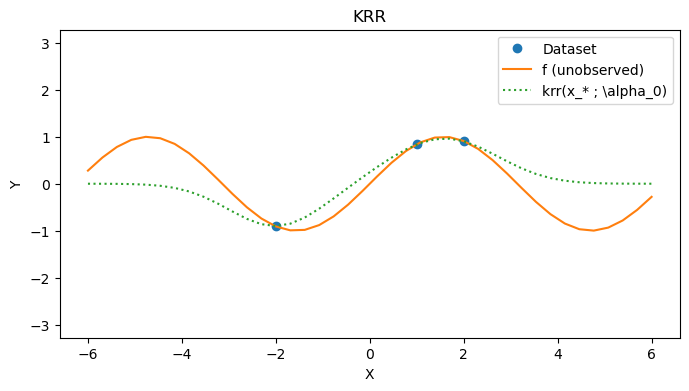

In [8]:
test_xs = jnp.linspace(-6, 6, 40).reshape(-1, 1)

with PlotContext(title="KRR", xlabel="X", ylabel="Y") as ax:
    # Plot dataset
    plt.plot(xs, ys, marker="o", linestyle="None", label="Dataset")
    plt.plot(test_xs, f(test_xs), label="f (unobserved)")

    # Plot KRR
    plt.plot(test_xs, [krr(k, xs, alpha_star, x) for x in test_xs], linestyle="dotted", label=r"krr(x_* ; \alpha_0)")

## Summary

1. Introduced KRR, a closely related model to GP regression.
2. Illustrated KRR on a toy dataset.

### Appendix: KRR

We can check that the minima of 

$$
\mathcal{L}(\alpha; \mathcal{D}) = (y - K_{xx}\alpha)^T \Sigma^{-1} (y - K_{xx}\alpha) + \alpha^T K_{xx} \alpha
$$

with respect to the KRR model is

$$
\alpha = (K_{xx} + \Sigma)^{-1}y \,.
$$

\begin{align*}
\operatorname{argmin}_\alpha \mathcal{L}(\alpha; \mathcal{D}) & \iff \nabla_{\alpha^T} \mathcal{L}(\alpha; \mathcal{D}) = 0 \tag{convex} \\
& \iff -K_{xx}\Sigma^{-1}y + K_{xx}\Sigma^{-1}K_{xx}\alpha + K_{MM}\alpha = 0 \tag{gradient} \\
& \iff K_{xx}\alpha + \Sigma\alpha = y \tag{multiply by $\Sigma K_{xx}^{-1}$ and rearrange} \\
& \iff \alpha = (K_{xx} + \Sigma)^{-1}y \tag{positive semi-definite}
\end{align*}

### Appendix: Checking Loss Minimization

As a sanity check, we can try to minimize the loss function with gradient descent to see if we get the same answer.

In [9]:
def grad_desc(loss: Callable, k: Array, Sigma: Array, xs: Array, ys: Array, alpha_0, lr=0.00001, iterations=100):
    """Simple gradient descent procedure to optimize loss function.
    """
    pbar = tqdm(range(iterations))
    losses = []
    for i in pbar:
        step = lr * jax.jacrev(loss, argnums=5)(k, Sigma, xs, ys, K_xx, alpha_0)
        alpha_0 = alpha_0 - step
        l = loss(k, Sigma, xs, ys, K_xx, alpha_0)
        losses += [l]
        pbar.set_postfix(loss=l)
    return alpha_0, losses

  0%|          | 0/100 [00:00<?, ?it/s]

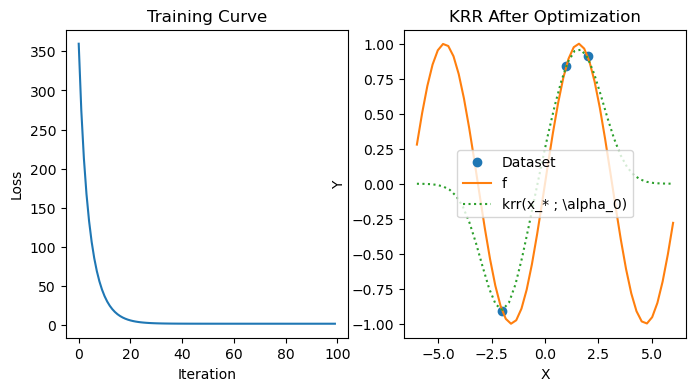

In [10]:
iterations = 100
alpha_star, losses = grad_desc(loss, k, Sigma, xs, ys, jnp.ones(N), lr=0.0005, iterations=iterations)
    
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(range(iterations), losses)
plt.title("Training Curve"); plt.xlabel("Iteration"); plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(xs, ys, marker="o", linestyle="None", label="Dataset")
plt.plot(jnp.linspace(-6, 6), f(jnp.linspace(-6, 6)), label="f")
plt.plot(test_xs, [krr(k, xs, alpha_star, x) for x in test_xs], linestyle="dotted", label=r"krr(x_* ; \alpha_0)")
plt.title("KRR After Optimization"); plt.xlabel("X"); plt.ylabel("Y"); plt.legend();

In [11]:
# Checking that the function space and weight space solutions agree
print("alpha", jnp.linalg.inv(K_xx + Sigma) @ ys)
print("alpha_*", alpha_star)

alpha [[-0.90569925]
 [ 0.47276443]
 [ 0.6166882 ]]
alpha_* [-0.90585166  0.48388898  0.6055647 ]
